In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 40*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-01-31 12:03:35.932784: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-31 12:03:36.086284: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-31 12:03:36.813050: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

In [725]:
sim_names = ["Koch_Meinhardt_1", "Koch_Meinhardt_2", "Koch_Meinhardt_3",
             "Koch_Meinhardt_4", "Koch_Meinhardt_5",
             "Koch_Meinhardt_6", "Koch_Meinhardt_7", "Koch_Meinhardt_9"]
sim_name = sim_names[0]
x_slice=slice(0,99,1)#slice(30,65,1)#slice(50,65,1)#
y_slice=slice(0,99,1)#slice(50,85,1)#slice(70,85,1)#
pattern = load(sim_name, x_slice, y_slice,
               data_time_start=-300,
               data_time_len=60,
               data_time_step=5)

In [4]:
x = tf.constant([0, 1, 2, 3], tf.float32)
y = tf.constant([0, 1, 2, 3], tf.float32)

x = 2.0 * (x - tf.reduce_min(x)) / (tf.reduce_max(x) - tf.reduce_min(x)) - 1.0
y = 2.0 * (y - tf.reduce_min(y)) / (tf.reduce_max(y) - tf.reduce_min(y)) - 1.0
X,Y = tf.meshgrid(x, y)
T = tf.fill(X.shape, 2.0)

H = tf.concat([tf.expand_dims(X, 0), 
                tf.expand_dims(Y, 0), 
                tf.expand_dims(T, 0)], axis=0)
#T = tf.concat([tf.fill(X.shape, i) for i in [2.,3.]])
# H = tf.concat([tf.concat([tf.expand_dims(X, 0), 
#                tf.expand_dims(Y, 0), 
#                tf.expand_dims(tf.fill(X.shape, i), 0)], axis=0) for i in [2., 3.]], axis=4)

In [6]:
W = tf.Variable(np.arange(0, 12).reshape((3, 4)), dtype=tf.float32)
#W = tf.Variable([[2, 2, 2], [2, 2, 2]], dtype=tf.float32)
print(W.shape)
print(H.shape)
#print(H)
tf.tensordot(W, H, axes=[[0], [0]]).shape

(3, 4)
(3, 4, 4)


2023-01-30 18:52:18.109733: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


TensorShape([4, 4, 4])

In [174]:

expand_ex(X, (0,1,2))

<tf.Tensor: shape=(1, 1, 1, 4, 4), dtype=float32, numpy=
array([[[[[-1.        , -0.3333333 ,  0.33333337,  1.        ],
          [-1.        , -0.3333333 ,  0.33333337,  1.        ],
          [-1.        , -0.3333333 ,  0.33333337,  1.        ],
          [-1.        , -0.3333333 ,  0.33333337,  1.        ]]]]],
      dtype=float32)>

In [213]:
def expand_ex(arr, dims):
    for d in dims:
        arr = tf.expand_dims(arr, d)
    return arr

ts = tf.constant([1,2,3], tf.float32)
x = tf.constant([0, 1, 2, 3], tf.float32)
y = tf.constant([0, 1, 2, 3], tf.float32)

x = 2.0 * (x - tf.reduce_min(x)) / (tf.reduce_max(x) - tf.reduce_min(x)) - 1.0
y = 2.0 * (y - tf.reduce_min(y)) / (tf.reduce_max(y) - tf.reduce_min(y)) - 1.0
X,Y = tf.meshgrid(x, y)

#T = tf.con tf.fill(X.shape, t
T = ts[:, tf.newaxis, tf.newaxis] * tf.ones(X.shape)[tf.newaxis, :, :]                   
H = tf.concat([tf.concat([expand_ex(X, (0,1)), 
                          expand_ex(Y, (0,1)),
                          expand_ex(tf.fill(X.shape, float(t)), (0,1))], axis=1) for t in ts], axis=0)

In [218]:
T

<tf.Tensor: shape=(3, 4, 4), dtype=float32, numpy=
array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.]],

       [[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]]], dtype=float32)>

In [211]:
X[tf.newaxis, :, :].shape

TensorShape([1, 4, 4])

In [217]:
tf.concat([X[tf.newaxis, tf.newaxis, :, :], 
           Y[tf.newaxis, tf.newaxis, :, :],
           T[tf.newaxis, :, :, :]], axis=1)

<tf.Tensor: shape=(1, 5, 4, 4), dtype=float32, numpy=
array([[[[-1.        , -0.3333333 ,  0.33333337,  1.        ],
         [-1.        , -0.3333333 ,  0.33333337,  1.        ],
         [-1.        , -0.3333333 ,  0.33333337,  1.        ],
         [-1.        , -0.3333333 ,  0.33333337,  1.        ]],

        [[-1.        , -1.        , -1.        , -1.        ],
         [-0.3333333 , -0.3333333 , -0.3333333 , -0.3333333 ],
         [ 0.33333337,  0.33333337,  0.33333337,  0.33333337],
         [ 1.        ,  1.        ,  1.        ,  1.        ]],

        [[ 1.        ,  1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ,  1.        ]],

        [[ 2.        ,  2.        ,  2.        ,  2.        ],
         [ 2.        ,  2.        ,  2.        ,  2.        ],
         [ 2.        ,  2.        ,  2.        ,  2.      

In [703]:
class NN_Field(tu.NN_base):
    def __init__(self, x_range, y_range, depth, dim_2d, layer_num, dtype=tf.float32, **kwargs):
        """A dense Neural Net that is specified by layers argument.

        layers: input, dense layers and outputs dimensions
        lb    : An array of minimums of inputs (lower bounds)
        ub    : An array of maximums of inputs (upper bounds)
        """
        super().__init__(dtype, **kwargs)
        self.depth = depth
        self.layer_num = layer_num
        self.dim_2d = dim_2d
        x = tf.constant(x_range, dtype=dtype)
        y = tf.constant(y_range, dtype=dtype)
        #Y,X = tf.meshgrid(x, y, indexing='ij')
        #X, Y = tf.meshgrid(x, y)
        Y, X = tf.meshgrid(x, y)
        self.X = X
        self.Y = Y
        self.domain_shape = X.shape
        self.build()
        
    def make_variables(self, k, initializer):
        return tf.Variable(initializer(shape=k, dtype=self.dtype))
    
                           
    def build(self):
        """Create the state of the layers (weights)"""
        weights = []
        scales = []
        biases = []
        
        rnd_init = tf.random_normal_initializer(stddev=1/6)
        W = tf.Variable(self.make_variables([self.depth, 3], rnd_init)
                        , dtype=self.dtype)
        #b = tf.Variable(tf.zeros([128, self.dim_2d[0], self.dim_2d[1]], dtype=self.dtype), dtype=self.dtype)
        a = tf.Variable(tf.ones([1, 1, 1, self.depth], dtype=self.dtype), dtype=self.dtype)
        b = tf.Variable(tf.zeros([1, 1, 1, self.depth], dtype=self.dtype), dtype=self.dtype)
        
        weights.append(W)
        scales.append(a)
        biases.append(b)
        for i in range(self.layer_num-1):
            rnd_init = tf.random_normal_initializer(stddev=1/(2*self.depth))
            W = tf.Variable(self.make_variables([self.depth, self.depth], rnd_init)
                        , dtype=self.dtype)
            #b = tf.Variable(tf.zeros([128, self.dim_2d[0], self.dim_2d[1]], dtype=self.dtype), dtype=self.dtype)
            a = tf.Variable(tf.ones([1, 1, self.depth], dtype=self.dtype), dtype=self.dtype)
            b = tf.Variable(tf.zeros([1, 1, self.depth], dtype=self.dtype), dtype=self.dtype)
        
            weights.append(W)
            scales.append(a)
            biases.append(b)
            
        rnd_init = tf.random_normal_initializer(stddev=1/4)
        W = tf.Variable(self.make_variables([2, self.depth], rnd_init)
                        , dtype=self.dtype)
        #b = tf.Variable(tf.zeros([2, self.dim_2d[0], self.dim_2d[1]], dtype=self.dtype), dtype=self.dtype)
        a = tf.Variable(tf.ones([1, 1, 2], dtype=self.dtype), dtype=self.dtype)
        b = tf.Variable(tf.zeros([1, 1, 2], dtype=self.dtype), dtype=self.dtype)
        
        weights.append(W)
        scales.append(a)
        biases.append(b)

        self.Ws = weights
        self.scales = scales
        self.bs = biases

    def make_inputs(self, ts):
        T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(self.X.shape)[:, :, tf.newaxis]       
        return T
        
    @tf.function
    def net(self, T):
        #T = tf.fill(self.domain_shape, t)
#         H = tf.concat([tf.expand_dims(self.X, 0), 
#                        tf.expand_dims(self.Y, 0), 
#                        tf.expand_dims(T, 0)], axis=0)
    

    
         
        
        #T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(self.X.shape)[:, :, tf.newaxis]
        #print(T)
        # H will be a tensor (batches, m, n, 3)
        # where batches is the len of ts,
        #       m,n are the width and hieght of the domain
        #       and 3 is for x,y,t
        H = tf.concat([tf.concat([self.X[tf.newaxis, :, :, tf.newaxis], 
                                 self.Y[tf.newaxis, :, :, tf.newaxis],
                                 T[:, :, i:i+1][tf.newaxis, :, :, :]], axis=3) for i in range(T.shape[-1])], axis=0)
        #print(H)
        def act(x):
            return x*tf.sigmoid(x)
        
        for W, a, b in zip(self.Ws, self.scales, self.bs):
            #print(W)
            mul_outputs = tf.tensordot(H, W, axes=[[-1], [-1]])
            #print(mul_outputs)
            outputs =  a * mul_outputs + b
            #outputs =  mul_outputs + b
            #print(outputs)
            #H = tf.tanh(outputs)
            #H = tf.sigmoid(outputs)
            H = act(outputs)
            #print(H)

        return outputs
    
    @tf.function
    def net2(self, t):                
        T = tf.fill(self.domain_shape, t)
        
        H = tf.concat([tf.expand_dims(self.X, 0), 
                       tf.expand_dims(self.Y, 0), 
                       tf.expand_dims(T, 0)], axis=0)
        
        for W, a, b in zip(self.Ws, self.scales, self.bs):
            mul_outputs = tf.tensordot(W, H, axes=[[0], [0]])
            #print(mul_outputs)
            outputs =  a * mul_outputs + b
            #print(outputs)
            H = tf.tanh(outputs)
            #print(H)

        return outputs

    def gradients(self, inputs, outputs):
        """finds the first and second order griadients of outputs at inputs

        Args:
           inputs: A tensor that has a shape [None, D1], where
                   D1 is the input dimensionality, specified in
                   the first element of layes.
           outputs:  A tensor that has a shape [None, Dn], where
                   Dn is the output dimensionality, specified in
                   the last element of layes.

        Return:   The returns 'partial_1' and 'partial_2' are the first and second
                  order gradients, repsectivly. Each one is a list that its elements
                  corresponds to one of the NN's last layer output. e.g. if the last layer
                  has Dn outputs, each list has Dn tensors as an elements. The dimensionality
                  of the tensors are the same as inputs: [None, D1]

        """
        partials_1 = [tf.gradients(outputs[:, i], inputs)[0] for i in range(outputs.shape[1])]
        partials_2 = [tf.gradients(partials_1[i], inputs)[0] for i in range(outputs.shape[1])]
        return partials_1, partials_2



In [767]:

# x = tf.constant(np.arange(x_slice.start, x_slice.stop)*pattern.simulation.L[0]/pattern.simulation.n[0], 
#                 dtype=tf.float32)
# y = tf.constant(np.arange(y_slice.start, y_slice.stop)*pattern.simulation.L[1]/pattern.simulation.n[0], 
#                 dtype=tf.float32)
x_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[0]
y_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[1]
x_range = x_range[x_slice]
y_range = y_range[y_slice]
optimizer=keras.optimizers.Adam(learning_rate=2e-4)
pinn = NN_Field(x_range, y_range, 
                depth=32, 
                dim_2d=(pattern.block_x, pattern.block_x), 
                layer_num = 6,
                dtype=tf.float32)
norm_l2 = L2()
#x = tf.constant(x_range[x_slice], dtype=tf.float32)
#y = tf.constant(y_range[y_slice], dtype=tf.float32)
#x = 2.0 * (x - tf.reduce_min(x)) / (tf.reduce_max(x) - tf.reduce_min(x)) - 1.0
#y = 2.0 * (y - tf.reduce_min(y)) / (tf.reduce_max(y) - tf.reduce_min(y)) - 1.0
#X,Y = tf.meshgrid(x, y)

D_u = pattern.params["D_u"]
D_v = pattern.params["D_u"]
sigma_u = pattern.params["sigma_u"]
sigma_v = pattern.params["sigma_v"]
mu_u = pattern.params["mu_u"]
rho_u = pattern.params["rho_u"]
rho_v = pattern.params["rho_v"]
kappa_u = pattern.params["kappa_u"]
#@tf.function
def grads(pinn, ts):
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(pinn.X)
        tape.watch(pinn.Y)        
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(pinn.X)
            tape2.watch(pinn.Y)
            T = pinn.make_inputs(ts)
            tape2.watch(T)     
            
            outputs = pinn.net(T)
        
            u = outputs[:, :, :, 0]
            v = outputs[:, :, :, 1]
            
        u_x = tape2.gradient(u, pinn.X)
        u_y = tape2.gradient(u, pinn.Y)
        u_t = tape2.gradient(u, T)
        v_x = tape2.gradient(v, pinn.X)
        v_y = tape2.gradient(v, pinn.Y)
        v_t = tape2.gradient(v, T)
            
    u_xx = tape.gradient(u_x, pinn.X)
    u_xy = tape.gradient(u_x, pinn.Y)
    u_yx = tape.gradient(u_y, pinn.X)
    u_yy = tape.gradient(u_y, pinn.Y)
    v_xx = tape.gradient(v_x, pinn.X)
    v_yy = tape.gradient(v_y, pinn.Y)
    v_xy = tape.gradient(v_x, pinn.Y)
    v_yx = tape.gradient(v_y, pinn.X)
    #return (u, u_xx, u_yy, u_t, v, v_xx, v_yy, v_t)
    return (tf.squeeze(u),
            tf.squeeze(u_xx), tf.squeeze(u_yy), tf.squeeze(u_xy), tf.squeeze(u_yx), tf.squeeze(u_t),
            tf.squeeze(v),
            tf.squeeze(v_xx), tf.squeeze(v_yy), tf.squeeze(v_xy), tf.squeeze(v_yx), tf.squeeze(v_t))
        
        
@tf.function
def train_step(elements):
    #t = elements[0][0]
    with tf.GradientTape(persistent=True) as tape: 
        tape.watch(pinn.X)
        tape.watch(pinn.Y)
        #tape.watch(t)
        trainables = pinn.trainable_variables
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(pinn.X)
            tape2.watch(pinn.Y)
            T = pinn.make_inputs(elements[0])
            #tape2.watch(T)
            
            outputs = pinn.net(T)            
            u = outputs[:, :, :, 0]
            v = outputs[:, :, :, 1]
            
            u_x = tape2.gradient(u, pinn.X)
            u_y = tape2.gradient(u, pinn.Y)
            #u_t = tape2.gradient(u, T)
            #u_t = tf.einsum("ijt -> tij", u_t)
            
            v_x = tape2.gradient(v, pinn.X)
            v_y = tape2.gradient(v, pinn.Y)
            #v_t = tape2.gradient(v, T)
            #v_t = tf.einsum("ijt -> tij", v_t)
            
        
        u_xx = tape.gradient(u_x, pinn.X)
        #u_xy = tape.gradient(u_x, pinn.Y)
        #u_yx = tape.gradient(u_y, pinn.X)
        u_yy = tape.gradient(u_y, pinn.Y)
        v_xx = tape.gradient(v_x, pinn.X)
        v_yy = tape.gradient(v_y, pinn.Y)
        #v_xy = tape.gradient(v_x, pinn.Y)
        #v_yx = tape.gradient(v_y, pinn.X)
        #print(u_xx)
        #partials_2 = [tf.gradients(partials_1[i], inputs)[0] for i in range(outputs.shape[1])]
               
        f = u * u * v / (1.0 + kappa_u * u * u)
        f_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u# - u_t
        f_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v# - v_t
        
        #print(u.shape)
        #print(u_xx.shape)
        #u_xyyx_diff = u_xy - u_yx
        #v_xyyx_diff = v_xy - v_yx

        #diff = outputs - elements[1] 
        #print(elements[1].shape)
        u_diff = u - elements[1][:, 0, :, :]
        v_diff = v - elements[1][:, 1, :, :]
        l2_u_obs = tf.reduce_sum(u_diff**2)
        l2_v_obs = tf.reduce_sum(v_diff**2)


        l2_res_u = tf.reduce_sum(f_u**2)
        l2_res_v = tf.reduce_sum(f_v**2)
        
        #l2_res_u_xyyx = tf.reduce_sum(u_xyyx_diff**2)
        #l2_res_v_xyyx = tf.reduce_sum(v_xyyx_diff**2)
        
        l2 = l2_u_obs + l2_v_obs + l2_res_u + l2_res_v #+ l2_res_u_xyyx + l2_res_v_xyyx
        
        
    grads = tape.gradient(l2, trainables)
    optimizer.apply_gradients(zip(grads, trainables))
    return (l2_u_obs, l2_v_obs, l2_res_u, l2_res_v)#, l2_res_u_xyyx, l2_res_v_xyyx)




In [768]:
def gen_series():    
    for i,t in enumerate(pattern.t_star):
        yield t, pattern.c[..., i]
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((), pattern.c.shape[:-1]))

In [769]:
pattern.t_star.shape

(12,)

In [792]:
#optimizer.lr.assign(1e-5)
def print_callback(printer, losses, epoch):
    printer(f"at epoch {epoch:d}\n"
            f" total loss: {np.sum(losses)}"
            f" u: {losses[0]}, v: {losses[1]},\n"
            f" Res u: {losses[2]}, Res v: {losses[3]} \n")
            #f" Res u xyyx: {losses[4]}, Res v xyyx: {losses[5]}")
losses = tu.train(epochs=200+1,
                  batch_size=1,
                  dataset = ds ,
                  train_step = train_step,
                  print_interval=10,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=None)


Start of epoch 0
at epoch 0
 total loss: 14255.2783203125 u: 13529.0224609375, v: 224.43798828125,
 Res u: 291.5293273925781, Res v: 210.28810119628906 

Time taken: 12.31s

Start of epoch 10
at epoch 10
 total loss: 13685.5322265625 u: 13040.2734375, v: 215.63430786132812,
 Res u: 211.7137451171875, Res v: 217.9097442626953 

Time taken: 3.28s

Start of epoch 20
at epoch 20
 total loss: 13593.328125 u: 12984.15234375, v: 209.43414306640625,
 Res u: 182.789794921875, Res v: 216.9513702392578 

Time taken: 3.31s

Start of epoch 30
at epoch 30
 total loss: 13494.7978515625 u: 12920.375, v: 203.85049438476562,
 Res u: 156.51272583007812, Res v: 214.0593719482422 

Time taken: 3.53s

Start of epoch 40
at epoch 40
 total loss: 13401.2587890625 u: 12858.732421875, v: 198.87774658203125,
 Res u: 133.97967529296875, Res v: 209.66929626464844 

Time taken: 3.38s

Start of epoch 50
at epoch 50
 total loss: 13305.8310546875 u: 12789.1279296875, v: 194.37657165527344,
 Res u: 116.61913299560547, 

In [802]:
losses_2 = tu.train(epochs=5000+1,
                  batch_size=1,
                  dataset = ds ,
                  train_step = train_step,
                  print_interval=100,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=None)


Start of epoch 0
at epoch 0
 total loss: 12608.322265625 u: 12050.705078125, v: 183.4689483642578,
 Res u: 138.0054931640625, Res v: 236.14260864257812 

Time taken: 0.48s

Start of epoch 100
at epoch 100
 total loss: 12419.703125 u: 11863.716796875, v: 182.8963623046875,
 Res u: 135.649658203125, Res v: 237.44024658203125 

Time taken: 36.19s

Start of epoch 200
at epoch 200
 total loss: 12212.5439453125 u: 11665.6142578125, v: 178.87710571289062,
 Res u: 136.33920288085938, Res v: 231.7136688232422 

Time taken: 37.26s

Start of epoch 300
at epoch 300
 total loss: 12016.2998046875 u: 11520.5390625, v: 178.32615661621094,
 Res u: 111.12397003173828, Res v: 206.31016540527344 

Time taken: 37.36s

Start of epoch 400
at epoch 400
 total loss: 11733.615234375 u: 11256.552734375, v: 170.84170532226562,
 Res u: 103.96365356445312, Res v: 202.25640869140625 

Time taken: 37.12s

Start of epoch 500
at epoch 500
 total loss: 11535.2314453125 u: 11066.9375, v: 168.4140167236328,
 Res u: 92.34


Start of epoch 4600
at epoch 4600
 total loss: 2424.60595703125 u: 1370.6806640625, v: 44.29975891113281,
 Res u: 172.7811279296875, Res v: 836.8443603515625 

Time taken: 35.08s

Start of epoch 4700
at epoch 4700
 total loss: 2351.64892578125 u: 1297.798828125, v: 42.44761276245117,
 Res u: 169.2926788330078, Res v: 842.1097412109375 

Time taken: 35.53s

Start of epoch 4800
at epoch 4800
 total loss: 2294.62255859375 u: 1246.552001953125, v: 40.50445556640625,
 Res u: 164.66714477539062, Res v: 842.899169921875 

Time taken: 35.24s

Start of epoch 4900
at epoch 4900
 total loss: 2293.9619140625 u: 1255.255859375, v: 41.87784194946289,
 Res u: 156.38002014160156, Res v: 840.4483642578125 

Time taken: 35.29s

Start of epoch 5000
at epoch 5000
 total loss: 2236.503173828125 u: 1180.163330078125, v: 40.91712188720703,
 Res u: 160.84890747070312, Res v: 854.5737915039062 

Time taken: 35.03s


In [811]:
losses_3 = tu.train(epochs=2000+1,
                  batch_size=1,
                  dataset = ds ,
                  train_step = train_step,
                  print_interval=100,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=None)


Start of epoch 0
at epoch 0
 total loss: 2228.75048828125 u: 1173.60302734375, v: 40.50519561767578,
 Res u: 160.77255249023438, Res v: 853.86962890625 

Time taken: 0.46s

Start of epoch 100
at epoch 100
 total loss: 2176.075439453125 u: 1114.8408203125, v: 38.33119201660156,
 Res u: 154.91641235351562, Res v: 867.9871215820312 

Time taken: 35.67s

Start of epoch 200
at epoch 200
 total loss: 2189.568359375 u: 1141.1929931640625, v: 37.445472717285156,
 Res u: 157.77459716796875, Res v: 853.1552734375 

Time taken: 37.21s

Start of epoch 300
at epoch 300
 total loss: 2069.866943359375 u: 1012.451904296875, v: 34.0501594543457,
 Res u: 151.22361755371094, Res v: 872.1412963867188 

Time taken: 36.84s

Start of epoch 400
at epoch 400
 total loss: 2146.9765625 u: 1098.1925048828125, v: 38.595375061035156,
 Res u: 164.4576416015625, Res v: 845.7311401367188 

Time taken: 36.18s

Start of epoch 500
at epoch 500
 total loss: 2047.4439697265625 u: 990.4048461914062, v: 34.668548583984375,


In [820]:
losses_4 = tu.train(epochs=3000+1,
                  batch_size=1,
                  dataset = ds ,
                  train_step = train_step,
                  print_interval=100,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=None)


Start of epoch 0
at epoch 0
 total loss: 1949.664306640625 u: 850.1898193359375, v: 37.194374084472656,
 Res u: 198.58795166015625, Res v: 863.6921997070312 

Time taken: 0.46s

Start of epoch 100
at epoch 100
 total loss: 1850.80126953125 u: 746.6010131835938, v: 38.57054138183594,
 Res u: 203.71932983398438, Res v: 861.910400390625 

Time taken: 38.44s

Start of epoch 200
at epoch 200
 total loss: 1814.5828857421875 u: 720.5481567382812, v: 33.88636016845703,
 Res u: 196.4496307373047, Res v: 863.69873046875 

Time taken: 39.21s

Start of epoch 300
at epoch 300
 total loss: 1786.4727783203125 u: 697.4108276367188, v: 35.107215881347656,
 Res u: 202.43130493164062, Res v: 851.5234375 

Time taken: 39.22s

Start of epoch 400
at epoch 400
 total loss: 1743.70703125 u: 633.297119140625, v: 34.46100997924805,
 Res u: 207.9619903564453, Res v: 867.9869384765625 

Time taken: 38.78s

Start of epoch 500
at epoch 500
 total loss: 1781.666259765625 u: 680.4024658203125, v: 33.528953552246094,

In [803]:
np.array(losses_2).shape

(60012, 4)

In [821]:
def sum_per(arr, element_nums_by=2):
    return np.sum(arr.reshape(-1, element_nums_by), axis=1)

losses2 = np.array(losses+losses_2+losses_3+losses_4)
element_nums_by = 12#len(losses)//2
losses2 =np.concatenate([sum_per(losses2[:, 0], element_nums_by)[:, np.newaxis],
                         sum_per(losses2[:, 1], element_nums_by)[:, np.newaxis],
                         sum_per(losses2[:, 2], element_nums_by)[:, np.newaxis],
                         sum_per(losses2[:, 3], element_nums_by)[:, np.newaxis],
                        # sum_per(losses2[:, 4], element_nums_by)[:, np.newaxis],
                        # sum_per(losses2[:, 5], element_nums_by)[:, np.newaxis]
                        ], axis=1)

#losses2.shape

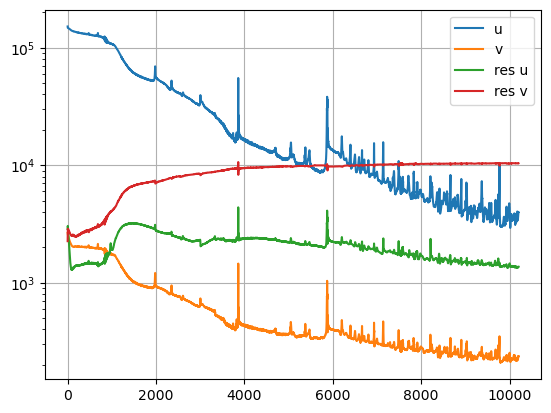

In [822]:
plt.plot(losses2[:, 0], label='u')
plt.plot(losses2[:, 1], label='v')
plt.plot(losses2[:, 2], label='res u')
plt.plot(losses2[:, 3], label='res v')
plt.yscale('log')
plt.grid(); plt.legend(); plt.show()

In [795]:
pattern.t_star.shape

(12,)

In [823]:
(u, u_xx, u_yy, u_xy, u_yx, u_t, 
 v, v_xx, v_yy, v_xy, v_yx, v_t) = grads(pinn, pattern.t_star[-1:].astype(np.float32))

In [824]:
def RMSE(arr1, arr2):
    return np.sqrt(np.mean(((arr1-arr2)/np.max(arr2))**2))
                          
print("u: ", RMSE(u, pattern.c[0,:, : , -1]))
print("v: ", RMSE(v, pattern.c[1,:, : , -1]))
print("u_xx: ", RMSE(u_xx, pattern.c_xx[0,:, : , -1]))
print("v_xx: ", RMSE(v_xx, pattern.c_xx[1,:, : , -1]))
print("u_yy: ", RMSE(u_yy, pattern.c_yy[0,:, : , -1]))
print("v_yy: ", RMSE(v_yy, pattern.c_yy[1,:, : , -1]))
print("u_t: ", RMSE(u_t, pattern.c_t[0,:, : , -1]))
print("v_t: ", RMSE(v_t, pattern.c_t[1,:, : , -1]))

u:  0.020809453
v:  0.028701436
u_xx:  0.15621136
v_xx:  0.16288634
u_yy:  0.16171831
v_yy:  0.18656611
u_t:  0.66493833
v_t:  1.541534


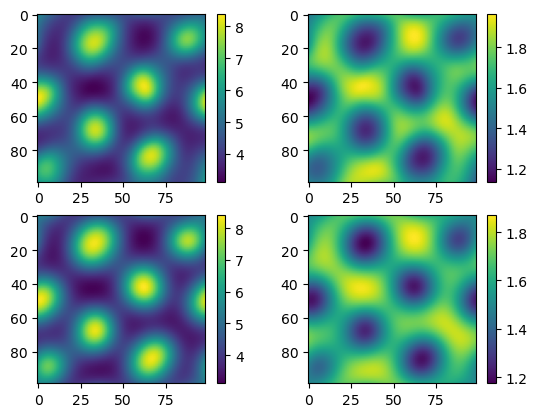

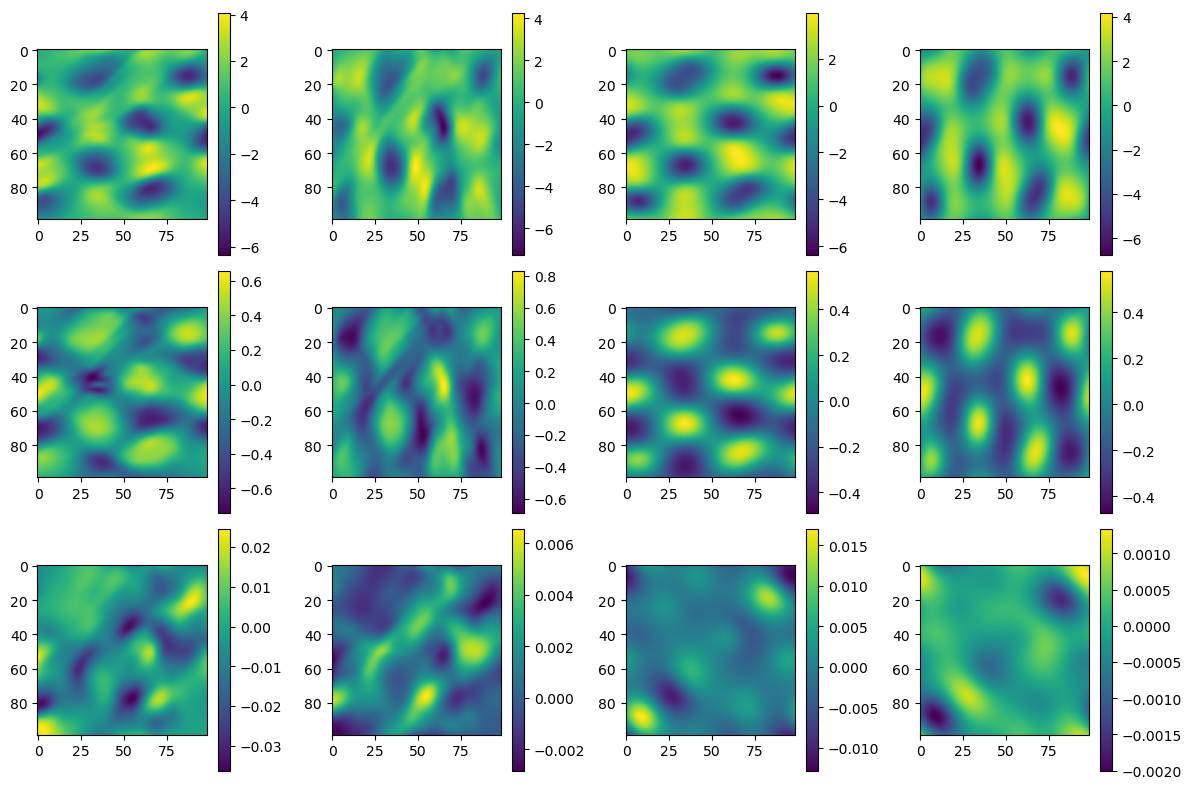

In [825]:
plt.subplot(221)
plt.imshow(u)
plt.colorbar()
plt.subplot(222)
plt.imshow(v)
plt.colorbar()
plt.subplot(223)
plt.imshow(pattern.c[0,:,:,-1])
plt.colorbar()
plt.subplot(224)
plt.imshow(pattern.c[1,:,:,-1])
plt.colorbar()
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(341)
plt.imshow(u_xx)
plt.colorbar()
plt.subplot(342)
plt.imshow(u_yy)
plt.colorbar()
plt.subplot(343)
plt.imshow(pattern.c_xx[0,:, : , -1])
plt.colorbar()
plt.subplot(344)
plt.imshow(pattern.c_yy[0,:, : , -1])
plt.colorbar()
plt.subplot(345)
plt.imshow(v_xx)
plt.colorbar()
plt.subplot(346)
plt.imshow(v_yy)
plt.colorbar()
plt.subplot(347)
plt.imshow(pattern.c_xx[1,:, : , -1])
plt.colorbar()
plt.subplot(3,4,8)
plt.imshow(pattern.c_yy[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.subplot(3,4,9)
plt.imshow(u_t)
plt.colorbar()
plt.subplot(3,4,10)
plt.imshow(v_t)
plt.colorbar()
plt.subplot(3,4,11)
plt.imshow(pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(3,4,12)
plt.imshow(pattern.c_t[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.show()

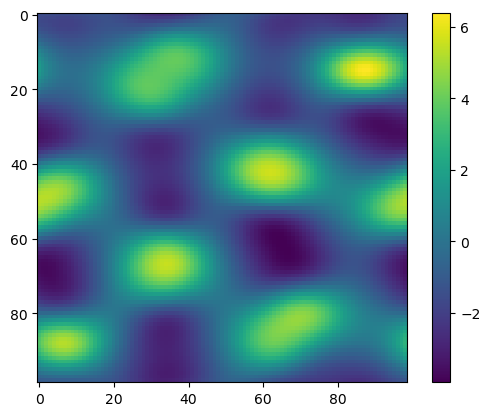

In [779]:
plt.imshow((u_xx-pattern.c_xx[0,:, : , -1]))
plt.colorbar()

In [851]:
optimizer2=keras.optimizers.Adam(learning_rate=2e-4)
pinn2 = NN_Field(x_range, y_range, 
                depth=32, 
                dim_2d=(pattern.block_x, pattern.block_x), 
                layer_num = 6,
                dtype=tf.float32)
norm_l2 = L2()

init_per = 2.0
D_u = tf.constant(pattern.params["D_u"], pinn.dtype, name="D_u")#tf.Variable(pattern.params["D_u"]*init_per, pinn.dtype)
D_v = tf.constant(pattern.params["D_v"], pinn.dtype, name="D_v")#tf.Variable(pattern.params["D_v"]*init_per, pinn.dtype)
def clip_by_value_zero_lb(z):
    return tf.clip_by_value(z, 0, 1e10,)

sigma_u = tf.Variable(pattern.params["sigma_u"]*init_per,
                      pinn.dtype,
                      name="sigma_u",
                      constraint=clip_by_value_zero_lb)


sigma_v = tf.Variable(pattern.params["sigma_v"]*init_per,
                      pinn.dtype,
                      name="sigma_v",
                      constraint=clip_by_value_zero_lb)

mu_u = tf.Variable(pattern.params["mu_u"]*init_per,
                   pinn.dtype,
                   name="mu_u",
                   constraint=clip_by_value_zero_lb)

rho_u = tf.Variable(pattern.params["rho_u"]*init_per,
                    pinn.dtype,
                    name="rho_u",
                    constraint=clip_by_value_zero_lb)

rho_v = tf.Variable(pattern.params["rho_v"]*init_per,
                    pinn.dtype,
                    name="rho_v",
                    constraint=clip_by_value_zero_lb)

kappa_u = tf.Variable(pattern.params["kappa_u"]*init_per,
                      pinn.dtype,
                      name="kappa_u",
                      constraint=clip_by_value_zero_lb)


params_tf = (sigma_u, sigma_v, mu_u, rho_u, rho_v, kappa_u,)

@tf.function
def train_step_inverse(elements):
    with tf.GradientTape(persistent=True) as tape: 
        tape.watch(pinn2.X)
        tape.watch(pinn2.Y)
        #tape.watch(t)
        trainables = pinn2.trainable_variables
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(pinn2.X)
            tape2.watch(pinn2.Y)
            T = pinn2.make_inputs(elements[0])
            #tape2.watch(T)
            
            outputs = pinn2.net(T)            
            u = outputs[:, :, :, 0]
            v = outputs[:, :, :, 1]
            
            u_x = tape2.gradient(u, pinn2.X)
            u_y = tape2.gradient(u, pinn2.Y)
            #u_t = tape2.gradient(u, T)
            #u_t = tf.einsum("ijt -> tij", u_t)
            
            v_x = tape2.gradient(v, pinn2.X)
            v_y = tape2.gradient(v, pinn2.Y)
            #v_t = tape2.gradient(v, T)
            #v_t = tf.einsum("ijt -> tij", v_t)
            
        
        u_xx = tape.gradient(u_x, pinn2.X)
        #u_xy = tape.gradient(u_x, pinn.Y)
        #u_yx = tape.gradient(u_y, pinn.X)
        u_yy = tape.gradient(u_y, pinn2.Y)
        v_xx = tape.gradient(v_x, pinn2.X)
        v_yy = tape.gradient(v_y, pinn2.Y)
        #v_xy = tape.gradient(v_x, pinn.Y)
        #v_yx = tape.gradient(v_y, pinn.X)
        #print(u_xx)
        #partials_2 = [tf.gradients(partials_1[i], inputs)[0] for i in range(outputs.shape[1])]
               
        f = u * u * v / (1.0 + kappa_u * u * u)
        f_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u# - u_t
        f_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v# - v_t
        
        #print(u.shape)
        #print(u_xx.shape)
        #u_xyyx_diff = u_xy - u_yx
        #v_xyyx_diff = v_xy - v_yx

        #diff = outputs - elements[1] 
        #print(elements[1].shape)
        u_diff = u - elements[1][:, 0, :, :]
        v_diff = v - elements[1][:, 1, :, :]
        l2_u_obs = tf.reduce_sum(u_diff**2)
        l2_v_obs = tf.reduce_sum(v_diff**2)


        l2_res_u = tf.reduce_sum(f_u**2)
        l2_res_v = tf.reduce_sum(f_v**2)
        
        #l2_res_u_xyyx = tf.reduce_sum(u_xyyx_diff**2)
        #l2_res_v_xyyx = tf.reduce_sum(v_xyyx_diff**2)
        
        l2 = l2_u_obs + l2_v_obs + l2_res_u + l2_res_v #+ l2_res_u_xyyx + l2_res_v_xyyx
        
       
    grads = tape.gradient(l2, trainables + params_tf)
    optimizer2.apply_gradients(zip(grads, trainables + params_tf))
    return (l2_u_obs, l2_v_obs, l2_res_u, l2_res_v)#, l2_res_u_xyyx, l2_res_v_xyyx)


In [852]:
def print_callback(printer, losses, epoch):
    printer(f"at epoch {epoch:d}\n"
            f" total loss: {np.sum(losses)}"
            f" u: {losses[0]}, v: {losses[1]},\n"
            f" Res u: {losses[2]}, Res v: {losses[3]} \n")
    printer(#f"D_u: {D_u.numpy()}, D_v: {D_v.numpy()} \n"
            f"rho_u: {rho_u.numpy()}, rho_v: {rho_v.numpy()} \n"
            f"sigma_u: {sigma_u.numpy()}, sigma_v: {sigma_v.numpy()} \n"
            f"kappa_u: {kappa_u.numpy()}, mu_u: {mu_u.numpy()} \n")
            #f" Res u xyyx: {losses[4]}, Res v xyyx: {losses[5]}")
losses = tu.train(epochs=10000+1,
                  batch_size=1,
                  dataset = ds ,
                  train_step = train_step_inverse,
                  print_interval=100,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=None)


Start of epoch 0
at epoch 0
 total loss: 361762.5625 u: 259720.71875, v: 24656.30078125,
 Res u: 38267.7421875, Res v: 39117.78125 

rho_u: 0.19832029938697815, rho_v: 0.05167919397354126 
sigma_u: 1.9976012706756592, sigma_v: 1.9975996017456055 
kappa_u: 1.729167161101941e-05, mu_u: 2.0018417835235596 

Time taken: 20.93s

Start of epoch 100
at epoch 100
 total loss: 20139.63671875 u: 16163.5224609375, v: 698.4473876953125,
 Res u: 2664.818603515625, Res v: 612.8468017578125 

rho_u: 0.21554476022720337, rho_v: 0.05487646535038948 
sigma_u: 2.0211474895477295, sigma_v: 1.9766165018081665 
kappa_u: 0.007432492449879646, mu_u: 1.9707772731781006 

Time taken: 35.31s

Start of epoch 200
at epoch 200
 total loss: 17249.11328125 u: 16010.373046875, v: 275.7044677734375,
 Res u: 734.348876953125, Res v: 228.68702697753906 

rho_u: 0.22547273337841034, rho_v: 0.05763161554932594 
sigma_u: 2.0422606468200684, sigma_v: 1.9658942222595215 
kappa_u: 0.0073623149655759335, mu_u: 1.95138669013977


Start of epoch 2400
at epoch 2400
 total loss: 6928.78857421875 u: 6485.9443359375, v: 128.16554260253906,
 Res u: 236.29916381835938, Res v: 78.37916564941406 

rho_u: 0.21722367405891418, rho_v: 0.017043787986040115 
sigma_u: 2.149090051651001, sigma_v: 0.5760862231254578 
kappa_u: 0.00696191331371665, mu_u: 1.8931058645248413 

Time taken: 35.92s

Start of epoch 2500
at epoch 2500
 total loss: 6366.49462890625 u: 5934.87451171875, v: 130.7014617919922,
 Res u: 232.8742218017578, Res v: 68.04421997070312 

rho_u: 0.21627502143383026, rho_v: 0.014924558810889721 
sigma_u: 2.1757047176361084, sigma_v: 0.5009448528289795 
kappa_u: 0.0072228261269629, mu_u: 1.8849639892578125 

Time taken: 37.59s

Start of epoch 2600
at epoch 2600
 total loss: 5881.3671875 u: 5482.060546875, v: 130.512451171875,
 Res u: 210.70077514648438, Res v: 58.09330749511719 

rho_u: 0.21497127413749695, rho_v: 0.013336220756173134 
sigma_u: 2.201223850250244, sigma_v: 0.4446858763694763 
kappa_u: 0.00736300181597


Start of epoch 4800
at epoch 4800
 total loss: 2507.8935546875 u: 2273.318359375, v: 84.01943969726562,
 Res u: 113.4525146484375, Res v: 37.103050231933594 

rho_u: 0.18610835075378418, rho_v: 0.01316537894308567 
sigma_u: 2.4456820487976074, sigma_v: 0.46196654438972473 
kappa_u: 0.004915833007544279, mu_u: 1.8089476823806763 

Time taken: 36.49s

Start of epoch 4900
at epoch 4900
 total loss: 2470.9091796875 u: 2235.916015625, v: 82.56184387207031,
 Res u: 114.08032989501953, Res v: 38.35102844238281 

rho_u: 0.18518267571926117, rho_v: 0.013215105049312115 
sigma_u: 2.4521303176879883, sigma_v: 0.4649091064929962 
kappa_u: 0.00483802380040288, mu_u: 1.8063892126083374 

Time taken: 36.92s

Start of epoch 5000
at epoch 5000
 total loss: 2410.82373046875 u: 2177.384033203125, v: 81.19065856933594,
 Res u: 113.42852783203125, Res v: 38.82052230834961 

rho_u: 0.1842576116323471, rho_v: 0.013258728198707104 
sigma_u: 2.4582033157348633, sigma_v: 0.4673881530761719 
kappa_u: 0.00476272


Start of epoch 7200
at epoch 7200
 total loss: 1229.0677490234375 u: 1033.40869140625, v: 50.156288146972656,
 Res u: 101.72972106933594, Res v: 43.77302551269531 

rho_u: 0.17660772800445557, rho_v: 0.015095536597073078 
sigma_u: 2.4478816986083984, sigma_v: 0.5466094017028809 
kappa_u: 0.0037778497207909822, mu_u: 1.7768733501434326 

Time taken: 37.00s

Start of epoch 7300
at epoch 7300
 total loss: 1236.66943359375 u: 1039.0240478515625, v: 49.40916061401367,
 Res u: 103.20930480957031, Res v: 45.02680206298828 

rho_u: 0.17653578519821167, rho_v: 0.015206808224320412 
sigma_u: 2.444458484649658, sigma_v: 0.5516487956047058 
kappa_u: 0.003784227417781949, mu_u: 1.776388168334961 

Time taken: 37.07s

Start of epoch 7400
at epoch 7400
 total loss: 1157.7913818359375 u: 973.6248779296875, v: 49.51512908935547,
 Res u: 88.57785034179688, Res v: 46.0734748840332 

rho_u: 0.17640171945095062, rho_v: 0.015261205844581127 
sigma_u: 2.441159725189209, sigma_v: 0.5562964677810669 
kappa_u:

at epoch 9500
 total loss: 873.9071655273438 u: 725.1702270507812, v: 36.27825927734375,
 Res u: 71.21630096435547, Res v: 41.242366790771484 

rho_u: 0.17452816665172577, rho_v: 0.016955647617578506 
sigma_u: 2.3919622898101807, sigma_v: 0.6251779198646545 
kappa_u: 0.0032565670553594828, mu_u: 1.7649043798446655 

Time taken: 34.88s

Start of epoch 9600
at epoch 9600
 total loss: 919.044921875 u: 774.38720703125, v: 36.45616912841797,
 Res u: 68.47611999511719, Res v: 39.725372314453125 

rho_u: 0.17443165183067322, rho_v: 0.017045270651578903 
sigma_u: 2.3897831439971924, sigma_v: 0.6285321116447449 
kappa_u: 0.0032252701930701733, mu_u: 1.7644709348678589 

Time taken: 37.45s

Start of epoch 9700
at epoch 9700
 total loss: 838.5133666992188 u: 694.1744384765625, v: 35.425785064697266,
 Res u: 68.72502136230469, Res v: 40.188133239746094 

rho_u: 0.17437292635440826, rho_v: 0.017086688429117203 
sigma_u: 2.38795804977417, sigma_v: 0.6299299597740173 
kappa_u: 0.003223658073693514, m

In [864]:
losses_2 = tu.train(epochs=10000+1,
                      batch_size=1,
                      dataset = ds ,
                      train_step = train_step_inverse,
                      print_interval=100,
                      loss_sample_interval = 1,
                      stop_threshold=1e-5,
                      print_callback = print_callback,
                      epoch_callback=None)


Start of epoch 0
at epoch 0
 total loss: 864.1348876953125 u: 726.2561645507812, v: 34.40031433105469,
 Res u: 64.84194946289062, Res v: 38.636444091796875 

rho_u: 0.1739588975906372, rho_v: 0.017372198402881622 
sigma_u: 2.3823628425598145, sigma_v: 0.6419554948806763 
kappa_u: 0.0031245772261172533, mu_u: 1.7624725103378296 

Time taken: 0.44s

Start of epoch 100
at epoch 100
 total loss: 829.762451171875 u: 695.8302001953125, v: 34.020694732666016,
 Res u: 61.68446350097656, Res v: 38.227108001708984 

rho_u: 0.17388346791267395, rho_v: 0.017444273456931114 
sigma_u: 2.380150318145752, sigma_v: 0.6452091336250305 
kappa_u: 0.003109836718067527, mu_u: 1.7620056867599487 

Time taken: 34.41s

Start of epoch 200
at epoch 200
 total loss: 789.108642578125 u: 650.5242919921875, v: 33.59700012207031,
 Res u: 65.06268310546875, Res v: 39.924705505371094 

rho_u: 0.17397230863571167, rho_v: 0.017386548221111298 
sigma_u: 2.3785345554351807, sigma_v: 0.6423588395118713 
kappa_u: 0.00312061


Start of epoch 2400
at epoch 2400
 total loss: 662.2598266601562 u: 546.4705200195312, v: 25.88494873046875,
 Res u: 52.48243713378906, Res v: 37.421932220458984 

rho_u: 0.17266811430454254, rho_v: 0.018772052600979805 
sigma_u: 2.3332865238189697, sigma_v: 0.6939690709114075 
kappa_u: 0.0028046430088579655, mu_u: 1.7511706352233887 

Time taken: 35.29s

Start of epoch 2500
at epoch 2500
 total loss: 600.5368041992188 u: 487.5875244140625, v: 24.526676177978516,
 Res u: 51.03900146484375, Res v: 37.383628845214844 

rho_u: 0.17244011163711548, rho_v: 0.018829353153705597 
sigma_u: 2.331808090209961, sigma_v: 0.6976856589317322 
kappa_u: 0.0027809462044388056, mu_u: 1.7505214214324951 

Time taken: 35.96s

Start of epoch 2600
at epoch 2600
 total loss: 592.5797119140625 u: 482.95367431640625, v: 25.351898193359375,
 Res u: 47.70567321777344, Res v: 36.568450927734375 

rho_u: 0.17231182754039764, rho_v: 0.018898174166679382 
sigma_u: 2.329526424407959, sigma_v: 0.7014287710189819 
kap


Start of epoch 4800
at epoch 4800
 total loss: 558.0685424804688 u: 461.88714599609375, v: 19.558746337890625,
 Res u: 42.482269287109375, Res v: 34.14036178588867 

rho_u: 0.17027132213115692, rho_v: 0.019695505499839783 
sigma_u: 2.28291916847229, sigma_v: 0.7367660403251648 
kappa_u: 0.0024845378939062357, mu_u: 1.732252836227417 

Time taken: 35.59s

Start of epoch 4900
at epoch 4900
 total loss: 512.3682861328125 u: 418.72979736328125, v: 19.45070457458496,
 Res u: 41.75862503051758, Res v: 32.42913055419922 

rho_u: 0.17022381722927094, rho_v: 0.019718870520591736 
sigma_u: 2.2794618606567383, sigma_v: 0.7390074133872986 
kappa_u: 0.0024603961501270533, mu_u: 1.73171865940094 

Time taken: 35.71s

Start of epoch 5000
at epoch 5000
 total loss: 495.10113525390625 u: 403.1881408691406, v: 18.543237686157227,
 Res u: 40.28153610229492, Res v: 33.088233947753906 

rho_u: 0.17007724940776825, rho_v: 0.01977517083287239 
sigma_u: 2.2772905826568604, sigma_v: 0.7404236793518066 
kappa_

at epoch 7100
 total loss: 406.90460205078125 u: 320.738037109375, v: 14.873274803161621,
 Res u: 37.61553955078125, Res v: 33.677764892578125 

rho_u: 0.1677481085062027, rho_v: 0.020664656534790993 
sigma_u: 2.2226555347442627, sigma_v: 0.780859649181366 
kappa_u: 0.0022138715721666813, mu_u: 1.7093440294265747 

Time taken: 34.90s

Start of epoch 7200
at epoch 7200
 total loss: 360.657470703125 u: 277.7537841796875, v: 14.096302032470703,
 Res u: 36.89002990722656, Res v: 31.91734504699707 

rho_u: 0.16764900088310242, rho_v: 0.02071704901754856 
sigma_u: 2.2203145027160645, sigma_v: 0.7801123261451721 
kappa_u: 0.002205169526860118, mu_u: 1.708191990852356 

Time taken: 34.04s

Start of epoch 7300
at epoch 7300
 total loss: 347.7906494140625 u: 262.17718505859375, v: 13.390260696411133,
 Res u: 39.54862594604492, Res v: 32.67457580566406 

rho_u: 0.1675158590078354, rho_v: 0.020754694938659668 
sigma_u: 2.2173798084259033, sigma_v: 0.7822897434234619 
kappa_u: 0.002195199253037572,

at epoch 9400
 total loss: 229.32037353515625 u: 158.34674072265625, v: 10.373537063598633,
 Res u: 32.027122497558594, Res v: 28.572975158691406 

rho_u: 0.16441398859024048, rho_v: 0.021323904395103455 
sigma_u: 2.1678128242492676, sigma_v: 0.8094140291213989 
kappa_u: 0.001976200146600604, mu_u: 1.6800416707992554 

Time taken: 36.30s

Start of epoch 9500
at epoch 9500
 total loss: 265.4366149902344 u: 195.18209838867188, v: 9.677083969116211,
 Res u: 31.643465042114258, Res v: 28.933984756469727 

rho_u: 0.1641499400138855, rho_v: 0.02143511176109314 
sigma_u: 2.166457414627075, sigma_v: 0.8115636706352234 
kappa_u: 0.0019649886526167393, mu_u: 1.6784268617630005 

Time taken: 36.16s

Start of epoch 9600
at epoch 9600
 total loss: 221.04202270507812 u: 152.01559448242188, v: 9.809697151184082,
 Res u: 31.85093116760254, Res v: 27.36579132080078 

rho_u: 0.16395416855812073, rho_v: 0.02141367271542549 
sigma_u: 2.1647348403930664, sigma_v: 0.8121802806854248 
kappa_u: 0.001952480059

In [870]:
losses_3 = tu.train(epochs=10000+1,
                      batch_size=1,
                      dataset = ds ,
                      train_step = train_step_inverse,
                      print_interval=100,
                      loss_sample_interval = 1,
                      stop_threshold=1e-5,
                      print_callback = print_callback,
                      epoch_callback=None)


Start of epoch 0
at epoch 0
 total loss: 232.6565704345703 u: 164.93838500976562, v: 9.946822166442871,
 Res u: 29.29842758178711, Res v: 28.47292709350586 

rho_u: 0.16329972445964813, rho_v: 0.021566353738307953 
sigma_u: 2.154369831085205, sigma_v: 0.8195663690567017 
kappa_u: 0.0019034676952287555, mu_u: 1.6716268062591553 

Time taken: 0.45s

Start of epoch 100
at epoch 100
 total loss: 217.95870971679688 u: 154.2491455078125, v: 8.847493171691895,
 Res u: 27.392133712768555, Res v: 27.469940185546875 

rho_u: 0.16305330395698547, rho_v: 0.021619845181703568 
sigma_u: 2.152552366256714, sigma_v: 0.8224671483039856 
kappa_u: 0.0018766422290354967, mu_u: 1.6701411008834839 

Time taken: 34.22s

Start of epoch 200
at epoch 200
 total loss: 222.54006958007812 u: 154.7117919921875, v: 10.134967803955078,
 Res u: 30.24177360534668, Res v: 27.45153045654297 

rho_u: 0.1629360020160675, rho_v: 0.021626660600304604 
sigma_u: 2.1500749588012695, sigma_v: 0.8241508603096008 
kappa_u: 0.0018


Start of epoch 2300
at epoch 2300
 total loss: 253.86175537109375 u: 201.83102416992188, v: 8.580238342285156,
 Res u: 21.255617141723633, Res v: 22.19487762451172 

rho_u: 0.15953153371810913, rho_v: 0.02207690291106701 
sigma_u: 2.0973846912384033, sigma_v: 0.8434098362922668 
kappa_u: 0.0016965438844636083, mu_u: 1.6376521587371826 

Time taken: 34.65s

Start of epoch 2400
at epoch 2400
 total loss: 243.20687866210938 u: 187.248046875, v: 8.50710678100586,
 Res u: 24.006507873535156, Res v: 23.445228576660156 

rho_u: 0.1593932807445526, rho_v: 0.02202759124338627 
sigma_u: 2.0951850414276123, sigma_v: 0.8430481553077698 
kappa_u: 0.0017069134628400207, mu_u: 1.6360557079315186 

Time taken: 33.97s

Start of epoch 2500
at epoch 2500
 total loss: 273.64556884765625 u: 216.42933654785156, v: 8.920974731445312,
 Res u: 23.718379974365234, Res v: 24.57688331604004 

rho_u: 0.15931037068367004, rho_v: 0.02200152538716793 
sigma_u: 2.0924384593963623, sigma_v: 0.8419362902641296 
kappa_u


Start of epoch 4600
at epoch 4600
 total loss: 113.96673583984375 u: 70.68046569824219, v: 6.051984786987305,
 Res u: 17.103343963623047, Res v: 20.130935668945312 

rho_u: 0.15568876266479492, rho_v: 0.02265443466603756 
sigma_u: 2.038494348526001, sigma_v: 0.8706651329994202 
kappa_u: 0.001485027838498354, mu_u: 1.6029967069625854 

Time taken: 34.34s

Start of epoch 4700
at epoch 4700
 total loss: 120.34459686279297 u: 77.14506530761719, v: 5.8076171875,
 Res u: 16.807559967041016, Res v: 20.58435821533203 

rho_u: 0.15554098784923553, rho_v: 0.02267126366496086 
sigma_u: 2.036360263824463, sigma_v: 0.870107114315033 
kappa_u: 0.0015026924666017294, mu_u: 1.6013730764389038 

Time taken: 34.06s

Start of epoch 4800
at epoch 4800
 total loss: 109.0338134765625 u: 67.49302673339844, v: 5.8011016845703125,
 Res u: 16.838050842285156, Res v: 18.901630401611328 

rho_u: 0.15538643300533295, rho_v: 0.02272837981581688 
sigma_u: 2.033336877822876, sigma_v: 0.8712859153747559 
kappa_u: 0.0


Start of epoch 6900
at epoch 6900
 total loss: 86.3202133178711 u: 49.53239440917969, v: 5.0199875831604,
 Res u: 14.98392105102539, Res v: 16.783912658691406 

rho_u: 0.1522018164396286, rho_v: 0.023030292242765427 
sigma_u: 1.9760633707046509, sigma_v: 0.8878545761108398 
kappa_u: 0.0013592883478850126, mu_u: 1.5674684047698975 

Time taken: 34.71s

Start of epoch 7000
at epoch 7000
 total loss: 85.40670013427734 u: 49.45377731323242, v: 4.492952346801758,
 Res u: 14.352033615112305, Res v: 17.107933044433594 

rho_u: 0.15201641619205475, rho_v: 0.023103924468159676 
sigma_u: 1.9737157821655273, sigma_v: 0.8888980746269226 
kappa_u: 0.0013486440293490887, mu_u: 1.5658743381500244 

Time taken: 34.64s

Start of epoch 7100
at epoch 7100
 total loss: 92.56793975830078 u: 55.351104736328125, v: 5.070997714996338,
 Res u: 15.2114839553833, Res v: 16.934350967407227 

rho_u: 0.15189477801322937, rho_v: 0.023081988096237183 
sigma_u: 1.9706883430480957, sigma_v: 0.8899426460266113 
kappa_u


Start of epoch 9200
at epoch 9200
 total loss: 118.65335845947266 u: 85.89390563964844, v: 4.580763816833496,
 Res u: 12.284069061279297, Res v: 15.89461612701416 

rho_u: 0.14825661480426788, rho_v: 0.023225661367177963 
sigma_u: 1.9076675176620483, sigma_v: 0.8976545333862305 
kappa_u: 0.0012654578313231468, mu_u: 1.5265341997146606 

Time taken: 35.19s

Start of epoch 9300
at epoch 9300
 total loss: 132.55902099609375 u: 97.74751281738281, v: 4.646883010864258,
 Res u: 13.689733505249023, Res v: 16.474889755249023 

rho_u: 0.14807142317295074, rho_v: 0.0232084933668375 
sigma_u: 1.9046779870986938, sigma_v: 0.8956392407417297 
kappa_u: 0.0012691334122791886, mu_u: 1.5243346691131592 

Time taken: 34.53s

Start of epoch 9400
at epoch 9400
 total loss: 134.36795043945312 u: 99.57705688476562, v: 4.959621906280518,
 Res u: 13.351873397827148, Res v: 16.479394912719727 

rho_u: 0.14791133999824524, rho_v: 0.023133467882871628 
sigma_u: 1.9007612466812134, sigma_v: 0.8971374034881592 
k

In [876]:
losses_4 = tu.train(epochs=10000+1,
                      batch_size=1,
                      dataset = ds ,
                      train_step = train_step_inverse,
                      print_interval=100,
                      loss_sample_interval = 1,
                      stop_threshold=1e-5,
                      print_callback = print_callback,
                      epoch_callback=None)


Start of epoch 0
at epoch 0
 total loss: 93.23538970947266 u: 58.54283905029297, v: 4.004907131195068,
 Res u: 14.453214645385742, Res v: 16.23442840576172 

rho_u: 0.14668285846710205, rho_v: 0.023287367075681686 
sigma_u: 1.8803248405456543, sigma_v: 0.8991258144378662 
kappa_u: 0.001229935442097485, mu_u: 1.5101141929626465 

Time taken: 0.47s

Start of epoch 100
at epoch 100
 total loss: 84.778076171875 u: 50.96862030029297, v: 4.014347553253174,
 Res u: 13.910318374633789, Res v: 15.884790420532227 

rho_u: 0.14656135439872742, rho_v: 0.023283593356609344 
sigma_u: 1.8764230012893677, sigma_v: 0.8993123769760132 
kappa_u: 0.0012246603146195412, mu_u: 1.5081027746200562 

Time taken: 33.29s

Start of epoch 200
at epoch 200
 total loss: 69.97190856933594 u: 38.05763626098633, v: 3.911543846130371,
 Res u: 12.897665023803711, Res v: 15.105066299438477 

rho_u: 0.14631801843643188, rho_v: 0.02324247919023037 
sigma_u: 1.8729758262634277, sigma_v: 0.899458646774292 
kappa_u: 0.0012375


Start of epoch 2300
at epoch 2300
 total loss: 61.687477111816406 u: 34.72193908691406, v: 3.2092432975769043,
 Res u: 10.962960243225098, Res v: 12.7933349609375 

rho_u: 0.14248330891132355, rho_v: 0.023609783500432968 
sigma_u: 1.7978309392929077, sigma_v: 0.9155684113502502 
kappa_u: 0.0011208553332835436, mu_u: 1.464309573173523 

Time taken: 34.07s

Start of epoch 2400
at epoch 2400
 total loss: 79.93197631835938 u: 51.4786262512207, v: 3.0023093223571777,
 Res u: 11.659616470336914, Res v: 13.79142951965332 

rho_u: 0.14223717153072357, rho_v: 0.02361549437046051 
sigma_u: 1.794704556465149, sigma_v: 0.916951060295105 
kappa_u: 0.0011144026648253202, mu_u: 1.4623490571975708 

Time taken: 34.60s

Start of epoch 2500
at epoch 2500
 total loss: 57.15556335449219 u: 31.913314819335938, v: 3.139338970184326,
 Res u: 10.125626564025879, Res v: 11.97728157043457 

rho_u: 0.14206643402576447, rho_v: 0.023582160472869873 
sigma_u: 1.791341781616211, sigma_v: 0.9157276749610901 
kappa_u


Start of epoch 4600
at epoch 4600
 total loss: 90.37532043457031 u: 64.61703491210938, v: 2.944502353668213,
 Res u: 11.310781478881836, Res v: 11.503002166748047 

rho_u: 0.13823814690113068, rho_v: 0.023735366761684418 
sigma_u: 1.7225483655929565, sigma_v: 0.9217550754547119 
kappa_u: 0.0010254166554659605, mu_u: 1.4192688465118408 

Time taken: 35.49s

Start of epoch 4700
at epoch 4700
 total loss: 152.62454223632812 u: 124.86639404296875, v: 4.19412088394165,
 Res u: 11.104888916015625, Res v: 12.459138870239258 

rho_u: 0.13820886611938477, rho_v: 0.023638205602765083 
sigma_u: 1.7196131944656372, sigma_v: 0.9190428853034973 
kappa_u: 0.0010448991088196635, mu_u: 1.4171873331069946 

Time taken: 34.76s

Start of epoch 4800
at epoch 4800
 total loss: 105.53033447265625 u: 78.09983825683594, v: 3.548774003982544,
 Res u: 10.342079162597656, Res v: 13.539639472961426 

rho_u: 0.1380678117275238, rho_v: 0.023689888417720795 
sigma_u: 1.7158668041229248, sigma_v: 0.9191277027130127 



Start of epoch 6900
at epoch 6900
 total loss: 58.8086051940918 u: 39.882225036621094, v: 2.0871212482452393,
 Res u: 7.952811241149902, Res v: 8.88644790649414 

rho_u: 0.13419607281684875, rho_v: 0.023926954716444016 
sigma_u: 1.6497381925582886, sigma_v: 0.9325746893882751 
kappa_u: 0.0008961126441136003, mu_u: 1.3766878843307495 

Time taken: 35.01s

Start of epoch 7000
at epoch 7000
 total loss: 56.973670959472656 u: 36.39533615112305, v: 2.154980182647705,
 Res u: 9.548502922058105, Res v: 8.87485122680664 

rho_u: 0.13400675356388092, rho_v: 0.023937689140439034 
sigma_u: 1.6464972496032715, sigma_v: 0.934516966342926 
kappa_u: 0.0009070552769117057, mu_u: 1.3748646974563599 

Time taken: 33.90s

Start of epoch 7100
at epoch 7100
 total loss: 56.004615783691406 u: 36.093074798583984, v: 2.016202926635742,
 Res u: 8.140802383422852, Res v: 9.75454044342041 

rho_u: 0.13383673131465912, rho_v: 0.023987147957086563 
sigma_u: 1.6437557935714722, sigma_v: 0.9351914525032043 
kappa_u


Start of epoch 9200
at epoch 9200
 total loss: 62.83740234375 u: 40.219390869140625, v: 2.0035364627838135,
 Res u: 11.249953269958496, Res v: 9.364522933959961 

rho_u: 0.1305331289768219, rho_v: 0.024063820019364357 
sigma_u: 1.5813294649124146, sigma_v: 0.9408646821975708 
kappa_u: 0.0008976702229119837, mu_u: 1.3360531330108643 

Time taken: 35.26s

Start of epoch 9300
at epoch 9300
 total loss: 44.529762268066406 u: 27.546226501464844, v: 1.9801976680755615,
 Res u: 7.41542387008667, Res v: 7.587913513183594 

rho_u: 0.13029173016548157, rho_v: 0.02401397004723549 
sigma_u: 1.5782405138015747, sigma_v: 0.9409553408622742 
kappa_u: 0.0008275113068521023, mu_u: 1.334614634513855 

Time taken: 35.91s

Start of epoch 9400
at epoch 9400
 total loss: 41.62308883666992 u: 25.8645076751709, v: 1.6473336219787598,
 Res u: 6.9246416091918945, Res v: 7.186607360839844 

rho_u: 0.1301390826702118, rho_v: 0.0240972638130188 
sigma_u: 1.5751806497573853, sigma_v: 0.9416306614875793 
kappa_u: 0

In [ ]:
'rho_u': 0.1  , 'rho_v': 0.025,
'sigma_u': 1.0, 'sigma_v': 1.0
'kappa_u': 0.0, 'mu_u': 1.0,

In [914]:
def Euclidian_L(vec1, vec2):
    def L(v):
        return np.sqrt(np.sum(v**2))
    v2 = vec2.copy()
    v2[v2==0] = 1
    return L((vec1-vec2)/v2)

u_vec_ac = np.array([pattern.params["rho_u"], pattern.params["mu_u"],
                     pattern.params["sigma_u"], pattern.params["kappa_u"]])

u_vec    = np.array([rho_u.numpy(), mu_u.numpy(), sigma_u.numpy(), kappa_u.numpy()])

v_vec_ac = np.array([pattern.params["rho_v"], 
                     pattern.params["sigma_v"], pattern.params["kappa_u"]])

v_vec    = np.array([rho_v.numpy(), sigma_v.numpy(), kappa_u.numpy()])

print(f"U params. estimates: {Euclidian_L(u_vec, u_vec_ac)}")
print(f"V params. estimates: {Euclidian_L(v_vec, v_vec_ac)}")

U params. estimates: 0.7080444112770643
V params. estimates: 0.0696769851474786


In [831]:
pattern.params

{'D_u': 0.1,
 'D_v': 1.0,
 'kappa_u': 0.0,
 'rho_u': 0.1,
 'mu_u': 1.0,
 'sigma_u': 1.0,
 'rho_v': 0.025,
 'sigma_v': 1.0}

In [877]:
losses2 = np.array(losses + losses_2+ losses_3+ losses_4)
element_nums_by = 12#len(losses)//2
losses2 =np.concatenate([sum_per(losses2[:, 0], element_nums_by)[:, np.newaxis],
                         sum_per(losses2[:, 1], element_nums_by)[:, np.newaxis],
                         sum_per(losses2[:, 2], element_nums_by)[:, np.newaxis],
                         sum_per(losses2[:, 3], element_nums_by)[:, np.newaxis],                        
                        ], axis=1)

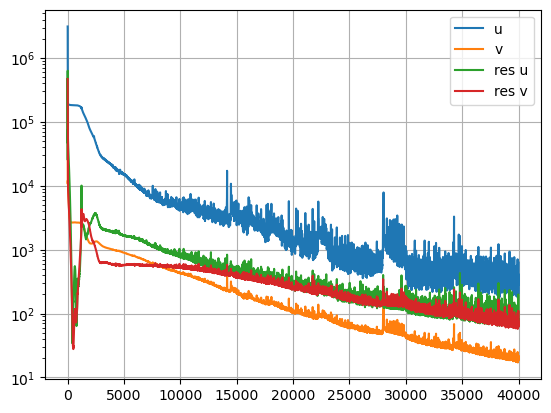

In [878]:
plt.plot(losses2[:, 0], label='u')
plt.plot(losses2[:, 1], label='v')
plt.plot(losses2[:, 2], label='res u')
plt.plot(losses2[:, 3], label='res v')
plt.yscale('log')
plt.grid(); plt.legend(); plt.show()

In [879]:
(u, u_xx, u_yy, u_xy, u_yx, u_t, 
 v, v_xx, v_yy, v_xy, v_yx, v_t) = grads(pinn2, pattern.t_star[-1:].astype(np.float32))

In [888]:
def RMSE(arr1, arr2):
    #return np.sqrt(np.mean(((arr1-arr2)/np.max(arr2))**2))
    return np.sqrt(np.mean(((arr1-arr2)/(arr2+1e-20))**2))
                          
print("u: ", RMSE(u, pattern.c[0,:, : , -1]))
print("v: ", RMSE(v, pattern.c[1,:, : , -1]))
print("u_xx: ", RMSE(u_xx, pattern.c_xx[0,:, : , -1]))
print("v_xx: ", RMSE(v_xx, pattern.c_xx[1,:, : , -1]))
print("u_yy: ", RMSE(u_yy, pattern.c_yy[0,:, : , -1]))
print("v_yy: ", RMSE(v_yy, pattern.c_yy[1,:, : , -1]))
print("u_t: ", RMSE(u_t, pattern.c_t[0,:, : , -1]))
print("v_t: ", RMSE(v_t, pattern.c_t[1,:, : , -1]))

u:  0.010844725
v:  0.008451183
u_xx:  24.017145
v_xx:  18.318129
u_yy:  39.647335
v_yy:  28.065193
u_t:  272.53345
v_t:  210.99806


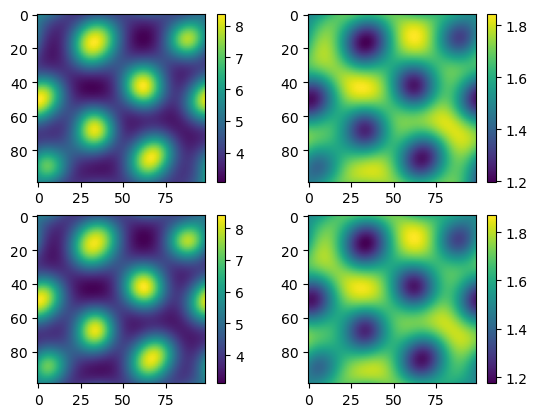

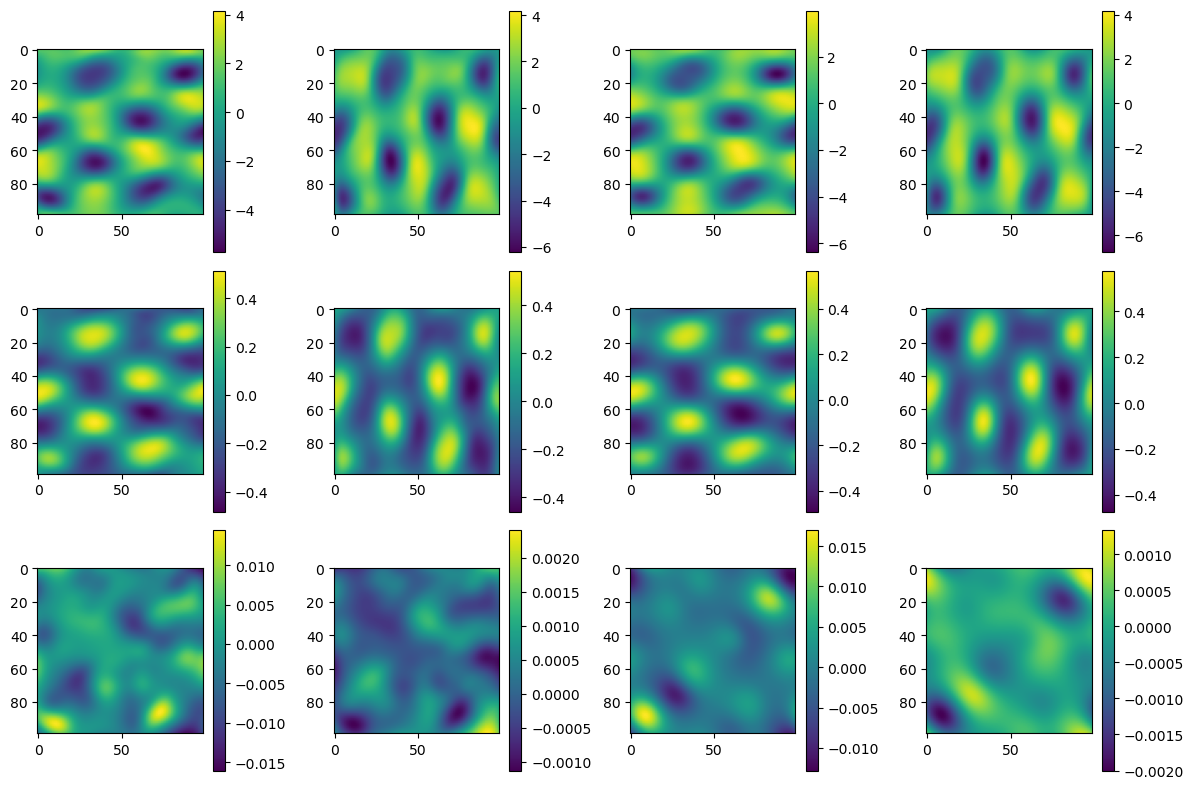

In [881]:
plt.subplot(221)
plt.imshow(u)
plt.colorbar()
plt.subplot(222)
plt.imshow(v)
plt.colorbar()
plt.subplot(223)
plt.imshow(pattern.c[0,:,:,-1])
plt.colorbar()
plt.subplot(224)
plt.imshow(pattern.c[1,:,:,-1])
plt.colorbar()
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(341)
plt.imshow(u_xx)
plt.colorbar()
plt.subplot(342)
plt.imshow(u_yy)
plt.colorbar()
plt.subplot(343)
plt.imshow(pattern.c_xx[0,:, : , -1])
plt.colorbar()
plt.subplot(344)
plt.imshow(pattern.c_yy[0,:, : , -1])
plt.colorbar()
plt.subplot(345)
plt.imshow(v_xx)
plt.colorbar()
plt.subplot(346)
plt.imshow(v_yy)
plt.colorbar()
plt.subplot(347)
plt.imshow(pattern.c_xx[1,:, : , -1])
plt.colorbar()
plt.subplot(3,4,8)
plt.imshow(pattern.c_yy[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.subplot(3,4,9)
plt.imshow(u_t)
plt.colorbar()
plt.subplot(3,4,10)
plt.imshow(v_t)
plt.colorbar()
plt.subplot(3,4,11)
plt.imshow(pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(3,4,12)
plt.imshow(pattern.c_t[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.show()

In [889]:
from scipy.optimize import lsq_linear
from scipy import linalg

u_vec_ac = np.array([pattern.params["rho_u"], pattern.params["mu_u"],
                     pattern.params["sigma_u"], pattern.params["kappa_u"]])

u_vec    = np.array([rho_u.numpy(), mu_u.numpy(), sigma_u.numpy(), kappa_u.numpy()])

v_vec_ac = np.array([pattern.params["rho_v"], 
                     pattern.params["sigma_v"], pattern.params["kappa_u"]])

v_vec    = np.array([rho_v.numpy(), sigma_v.numpy(), kappa_u.numpy()])

params2 = np.concatenate([u_vec[:-1], v_vec[:-1]])
params3 = np.concatenate([u_vec_ac[:-1], v_vec_ac[:-1]])

u_sol = u.numpy().flatten()
v_sol = v.numpy().flatten()
n2 = u_sol.shape[0]
kappa_sol = kappa_u.numpy()#pde_resKM.kappa_u.get_value(0).numpy()[0]

f_sol = u_sol * u_sol * v_sol / (1.0 + kappa_sol * u_sol * u_sol)


uxxyy_sol = D_u.numpy()*(u_xx.numpy() + u_yy.numpy()).flatten()
vxxyy_sol = D_v.numpy()*(v_xx.numpy() + v_yy.numpy()).flatten()

A_sol =  np.vstack((np.c_[f_sol,  u_sol,  [1]*n2, [0]*n2, [0]*n2],
                    np.c_[[0]*n2, [0]*n2, [0]*n2,-f_sol,  [1]*n2]))


u_dt_sol = (u_t.numpy()).flatten()
v_dt_sol = (v_t.numpy()).flatten()

b_sol =  np.r_[(u_dt_sol-uxxyy_sol, v_dt_sol-vxxyy_sol)]

In [890]:
np.sqrt(np.mean(((np.dot(A_sol, params2)-b_sol))**2))

9.613109484046875

In [891]:
np.sqrt(np.mean(((np.dot(A_sol, params3)-b_sol))**2))

7.198399595587393